In [1]:
import os
import numpy as np
import pandas as pd

from const import *
from data_io import get_poster, plot_poster
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input, Model, datasets
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# read encode dataframe and select only 3 genres
encoded_genre_df = pd.read_csv('encoded_genres.csv', index_col=0)
encoded_genre_df = encoded_genre_df[['_Action', '_Romance', '_Thriller']]
genre_count = np.sum(encoded_genre_df * 1, axis=1)
encoded_filtered = encoded_genre_df.loc[genre_count == 1]

# consider only movies released in year 2000-2024
valid_movies = encoded_genre_df.index
movie_year = pd.read_csv('movies.csv', index_col=0)
movie_year = movie_year['date']
mov = []
for i in valid_movies:
    mov.append(movie_year.iloc[i-1000001])
movie_year = pd.DataFrame(mov)
movie_year.index = valid_movies
movie_year = movie_year.loc[genre_count == 1]


encoded_filtered = encoded_filtered.loc[(movie_year.iloc[:,0] >= 2000) & (movie_year.iloc[:,0] <= 2024)]

In [2]:
# how many movies in each genre
np.sum(encoded_filtered, axis=0)

_Action      14420
_Romance     25433
_Thriller    22793
dtype: int64

In [3]:
# how many samples are there
print(encoded_filtered.shape)

(62646, 3)


In [4]:
movie = []
encode = []
n_genre = encoded_filtered.shape[1]
IMG_SIZE = (345, 230, 3)
size = 4000

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = encoded_filtered.loc[encoded_filtered.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie = np.array(movie)
encode = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

In [5]:
# confirm we have 4000 movies in each genre
sum_genre_filtered = np.sum(encode, axis=0)
print(sum_genre_filtered)

[4000. 4000. 4000.]


In [6]:
# split 4000 movies into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(movie, encode, test_size=0.2, random_state=4012)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications.vgg16 import VGG16

# use VGG16 as pre-trained model 
vgg16_base = VGG16(weights='imagenet', 
                   include_top=False,
                   input_shape =(345, 230, 3))

vgg16_base.trainable = False
print(vgg16_base.summary())

inputs = Input(shape = (345, 230, 3))
x = vgg16_base(inputs, training=False)

#x = Conv2D(128, (3, 3), activation ='relu', padding = 'Same')(x)
#x = Conv2D(128, (3, 3), activation ='relu', padding = 'Same')(x)
#x = Conv2D(128, (3, 3), activation ='relu', padding = 'Same')(x)
#x = MaxPooling2D((2, 2))(x)
#x = Dropout(0.25)(x)

# flatten the ouptut from VGG16 to train our DNN 
x = Flatten()(x)
x = Dense(128, activation = 'sigmoid')(x)
x = Dropout(0.25)(x)
outputs = Dense(n_genre, activation = 'softmax')(x)

model = Model(inputs, outputs)

print(model.summary())

2024-04-13 21:59:18.368264: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-13 21:59:18.368411: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-13 21:59:18.368435: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-13 21:59:18.368522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-13 21:59:18.368571: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 345, 230, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 345, 230, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 345, 230, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 172, 115, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 172, 115, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 172, 115, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 86, 57, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 86, 57, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 86, 57, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 86, 57, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 43, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 43, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 43, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 43, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 21, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 21, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 21, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 21, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 10, 7, 512)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 345, 230, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 10, 7, 512)     │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 35840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,587,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,302,723 (73.63 MB)

 Trainable params: 4,588,035 (17.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [8]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

tf.random.set_seed(4013)
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50


2024-04-13 21:59:23.004887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


240/240 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.4264 - loss: 1.1137 - val_accuracy: 0.5542 - val_loss: 0.9900
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 566s 2s/step - accuracy: 0.5173 - loss: 0.9857 - val_accuracy: 0.5453 - val_loss: 0.9746
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.5390 - loss: 0.9654 - val_accuracy: 0.5740 - val_loss: 0.9381
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 544s 2s/step - accuracy: 0.5822 - loss: 0.9212 - val_accuracy: 0.5719 - val_loss: 0.9262
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.5774 - loss: 0.9114 - val_accuracy: 0.5714 - val_loss: 0.9256
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 536s 2s/step - accuracy: 0.5807 - loss: 0.9035 - val_accuracy: 0.5688 - val_loss: 0.9286
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 616s 3s/step - accuracy: 0.6039 - loss: 0.8828 - val_accuracy: 0.5813 - val_loss: 0.9379
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.6005 - loss: 0.8795 - val_accuracy: 0.579

In [9]:
# put model onto testing dataset
predy = model.predict(X_test)
predy_class = np.argmax(predy, axis=1)
truey_class = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(truey_class, predy_class))


75/75 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step
[[482 134 184]
 [119 510 150]
 [169 170 482]]


In [10]:
from tensorflow.keras.metrics import AUC
tf_auc = AUC(num_thresholds = 200, from_logits = True, multi_label = True)
tf_auc.update_state(y_test, predy)
print(tf_auc.result().numpy())

0.7903587


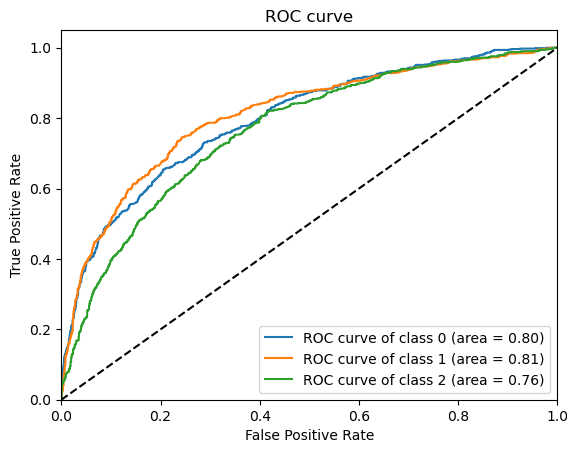

In [11]:
# plot ROC curve and compute AUC
from tensorflow.keras.ops import softmax
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

# feed predy into softmax function for actual probabilities
probi_y = softmax(predy, axis=-1)
for i in range(n_genre):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], probi_y[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_genre):
    plt.plot(fpr[i], tpr[i], label = 'ROC curve of class {0} (area = {1:0.2f})'
                                     ''.format(i, roc_auc[i]))
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc = 'lower right')
plt.show
plt.savefig('ROC.png', dpi=300)

In [13]:
# mean f1 score for all genres together
from sklearn.metrics import f1_score
f1 = f1_score(truey_class, predy_class, average='macro')
print(f1)

0.6143987195086441


In [14]:
# save model for future analysis
model.save("CNN_vgg16.keras")